In [ ]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

# dataset: MIND-small

In [4]:
news = 'MINDsmall_train/news.tsv'
behavior = 'MINDsmall_train/behaviors.tsv'
#news_test = 'MINDlarge_test/news.tsv'
#news_valid = 'MINDlarge_val/news.tsv'

#entity_embedding.vec ->	The embeddings of entities in news extracted from knowledge graph 
#relation_embedding.vec	->  The embeddings of relations between entities extracted from knowledge graph
#both [ID (retrievable from news dataset: columns) - EMB VALUES]

#-------------------------------------------------------------------------------------------------
def load_news_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities "]
    
    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    
    return df

#news_df.shape

news, behavior = load_news_df(news), load_news_df(behavior)
#test = load_news_df(news_test)
#valid = load_news_df(news_valid)
#print(train.shape, test.shape, valid.shape)

#TO-DO: 16sec is too much, save a subset of the dataset


In [5]:

"@TO-DO: use only news with category = 'news' & subcategory = 'newspolitics'"
#news = news[(news['Category'] == 'news') & (news['SubCategory'] == 'newspolitics')]
#news.shape--->(51282, 8)

news.shape

(51282, 8)

In [6]:
behavior.shape#--->(156965, 5)
behavior["History"] = behavior["History"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])


In [7]:
#initialize interaction matrix shape (users, news)
interaction_matrix_small = pd.DataFrame(0, index=behavior['User ID'].unique(), columns=news['News ID'].unique())
#NEXT: populate it using both history and impressions

**Q: binary coding (1,0) vs ternary coding (1,0,-1)** ? <br>
PRO (TERNARY): deeplearning algo leverage negative feedback efficiently<br>
CONTRO: More complex, possible noise (non click != non interest is not given)

In [8]:
#binary encoding
for _, row in behavior.iterrows():
    user_id = row['User ID']
    history_news_ids = row['History']  
    
    for news_id in history_news_ids:
        if news_id in interaction_matrix_small.columns:
            interaction_matrix_small.at[user_id, news_id] = 1
            
#this takes 45 sec - 1 min

In [9]:
interaction_matrix_small = interaction_matrix_small.astype('int8')

In [10]:
#save interaction matrix
interaction_matrix_small.to_parquet('interaction_matrix_small.parquet') #only with History data
#takes 50 sec

In [11]:
behavior["Impressions"] = behavior["Impressions"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])

In [13]:
for _, row in behavior.iterrows():
    user_id = row['User ID']
    impressions = row['Impressions']  

    for impression in impressions:
        news_id, clicked = impression.split('-')  # pair (news, clicked (1 or 0))
        if clicked == '1' and news_id in interaction_matrix_small.columns:
            interaction_matrix_small.at[user_id, news_id] = 1
#9secs!

In [14]:
interaction_matrix_small.to_parquet('interaction_matrix_small.parquet') # with History + Impressions data

In [15]:
#Filter out user and news that have/been interacted less than 5 times
# columns = news IDs
cols_to_keep = interaction_matrix_small.columns[interaction_matrix_small.sum(axis=0) >= 5]
interaction_matrix_filtered = interaction_matrix_small[cols_to_keep]

# rows = user IDs
rows_to_keep = interaction_matrix_filtered.index[interaction_matrix_filtered.sum(axis=1) >= 5]
interaction_matrix_filtered = interaction_matrix_filtered.loc[rows_to_keep]


In [24]:
interaction_matrix_filtered.shape

(46600, 15520)

In [27]:
#ensure every user has interacted with at least 5 news, and every news has been clicked by at least 5 users
def filter_interaction_matrix(matrix, min_interactions=5):
    while True:
        user_interactions = matrix.sum(axis=1)
        news_interactions = matrix.sum(axis=0)
        users_to_keep = user_interactions[user_interactions >= min_interactions].index
        news_to_keep = news_interactions[news_interactions >= min_interactions].index
        new_matrix = matrix.loc[users_to_keep, news_to_keep]
        if new_matrix.shape == matrix.shape:
            break
        matrix = new_matrix

    return new_matrix

interaction_matrix_filtered = filter_interaction_matrix(interaction_matrix_small)


In [29]:

min_interactions_per_user = interaction_matrix_filtered.sum(axis=1).min()
min_interactions_per_news = interaction_matrix_filtered.sum(axis=0).min()

print("min int per user:", min_interactions_per_user)
print("min int per news:", min_interactions_per_news)
print(interaction_matrix_filtered.shape)


Minimum interactions per user: 5
Minimum interactions per news item: 5
(46594, 15471)


In [35]:
#interaction_matrix_filtered.to_parquet('filtered_interaction_matrix.parquet')


_______________________________________________________________________________

In [37]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Convert DataFrame to a Sparse Matrix (if it's not already in that format)
interaction_matrix_csr = csr_matrix(interaction_matrix_filtered.values)


In [38]:
# Extracting Non-Zero Interactions
users, items = interaction_matrix_csr.nonzero()
interactions = list(zip(users, items))


In [39]:
train_interactions, test_interactions = train_test_split(interactions, test_size=0.2, random_state=42)


In [40]:
from scipy.sparse import coo_matrix

# Function to create a sparse matrix from interactions
def create_sparse_matrix(interactions, shape):
    row, col = zip(*interactions)
    data = np.ones(len(interactions))
    return coo_matrix((data, (row, col)), shape=shape)

# Create training and test sparse matrices
train_matrix = create_sparse_matrix(train_interactions, interaction_matrix_csr.shape)
test_matrix = create_sparse_matrix(test_interactions, interaction_matrix_csr.shape)


In [41]:
# Convert interaction lists back to sets of users
train_users = set(user for user, _ in train_interactions)
test_users = set(user for user, _ in test_interactions)

# Check if all test users are in train users
missing_users = test_users - train_users
print("Number of users in test set but not in training set:", len(missing_users))


Number of users in test set but not in training set: 0


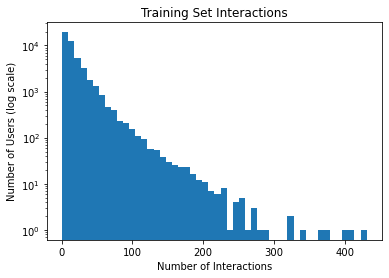

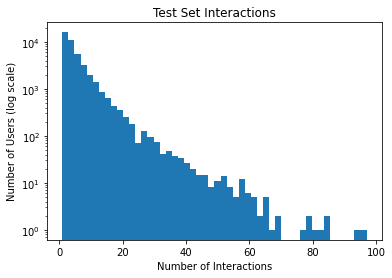

In [42]:
import matplotlib.pyplot as plt

# Function to plot interaction distribution
def plot_interaction_distribution(interactions, title):
    user_interactions = {}
    for user, _ in interactions:
        user_interactions[user] = user_interactions.get(user, 0) + 1

    plt.hist(user_interactions.values(), bins=50, log=True)
    plt.title(title)
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Users (log scale)')
    plt.show()

# Plot distribution for training and test sets
plot_interaction_distribution(train_interactions, 'Training Set Interactions')
plot_interaction_distribution(test_interactions, 'Test Set Interactions')


In [43]:
# Calculate sparsity
def calculate_sparsity(matrix):
    total_possible_interactions = matrix.shape[0] * matrix.shape[1]
    actual_interactions = len(matrix.nonzero()[0])
    sparsity = 1 - (actual_interactions / total_possible_interactions)
    return sparsity

train_sparsity = calculate_sparsity(train_matrix)
test_sparsity = calculate_sparsity(test_matrix)

print("Training Set Sparsity:", train_sparsity)
print("Test Set Sparsity:", test_sparsity)


Training Set Sparsity: 0.9987816161960853
Test Set Sparsity: 0.9996954037022113


In [44]:
print("Number of interactions in the training set:", len(train_interactions))
print("Number of interactions in the test set:", len(test_interactions))


Number of interactions in the training set: 878279
Number of interactions in the test set: 219570
